# Bagging

In [66]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [67]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo
import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [68]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [69]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


# Entrenamiento

In [70]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [71]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [72]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

### Random Search

In [74]:
params = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 50),
          'n_estimators': np.arange(1, 50),
         }

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(criterion="entropy")
)

rgscv = RandomizedSearchCV(
    model_bagging, params, n_iter=60, scoring='accuracy', cv=5, return_train_score=True
).fit(X_train, y_train)

In [75]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.7966666666666666
Best params {'n_estimators': 40, 'max_samples': 31, 'max_features': 11}


In [76]:
rgscv.best_params_['n_estimators']

40

In [77]:
rgscv.best_params_['max_samples']

31

In [78]:
rgscv.best_params_['max_features']

11

## Accuracy

In [79]:
accuracy_score(y_test, rgscv.predict(X_test))

0.8208955223880597

## Precision

In [80]:
precision_score(y_test, rgscv.predict(X_test))

0.8275862068965517

## Recall

In [81]:
recall_score(y_test, clf.predict(X_test), pos_label=0)

1.0

## F1-Score

In [82]:
f1_score(y_test, clf.predict(X_test))

0.0

## Matriz de Cofusion

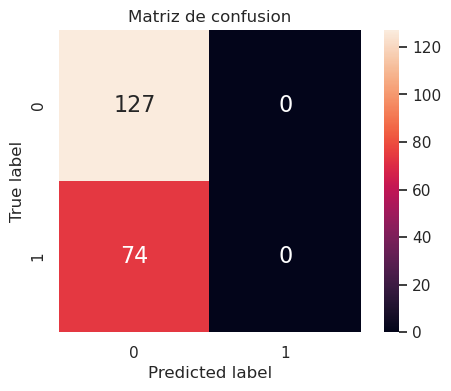

In [83]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, clf.predict(X_test))

## Curva ARUC ROC

In [84]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

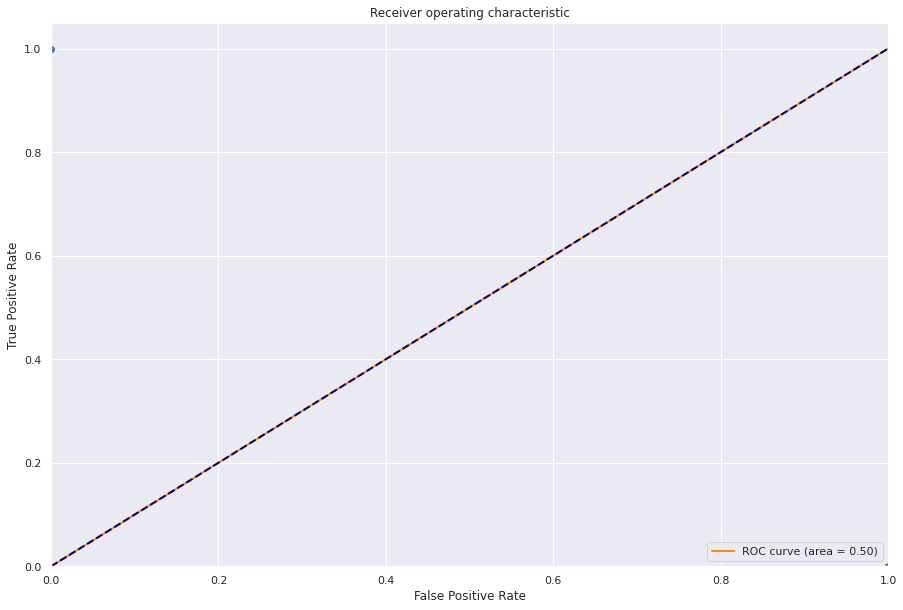

0.5

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, clf.predict(X_test)))

In [86]:
# TODO: arreglar este modelo, esta randomizado, siempre predice 0